Lettura file: 101_mat_ricette_output.txt
 -> 100x100 (Simmetrizzazione)... ✅ OK!

--- ANALISI BACKBONE: Tradizionale (101) ---
Tabella salvata in: tabella_legami_Tradizionale.csv
Top 10 Legami più forti:
 Nodo A  Nodo B  Peso (Forza Legame)
     69      73                   14
     31      32                   12
     42      69                   12
     25      26                   11
     60      69                   11
     34      72                   10
     26      42                   10
     32      69                   10
     32      68                   10
     34      60                   10


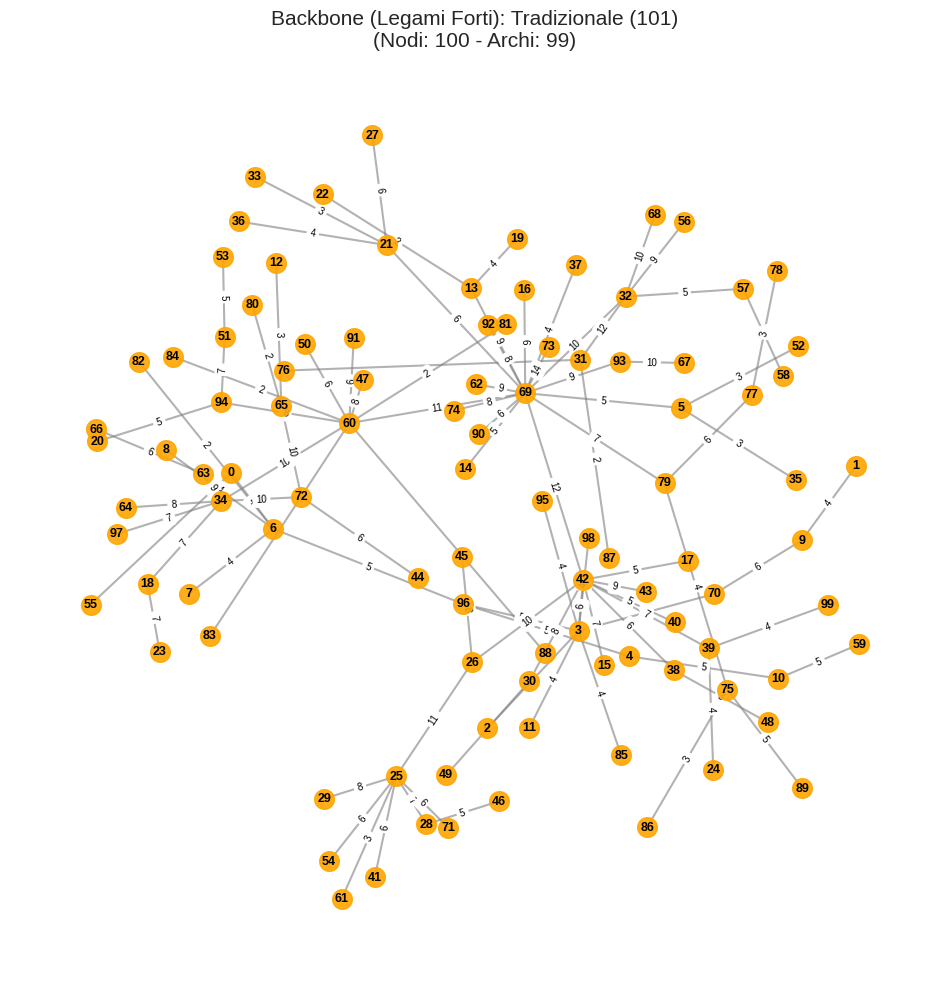

Lettura file: Roca_mat_ricette_output.txt
 -> 57x57 (Simmetrizzazione)... ✅ OK!

--- ANALISI BACKBONE: Alta Cucina (Roca) ---
Tabella salvata in: tabella_legami_Alta.csv
Top 10 Legami più forti:
 Nodo A  Nodo B  Peso (Forza Legame)
     14      15                   20
      4      18                   18
     15      18                   17
      3      35                   16
     13      15                   15
     18      41                   14
      1      13                   14
     15      22                   13
     13      35                   12
     15      19                   12


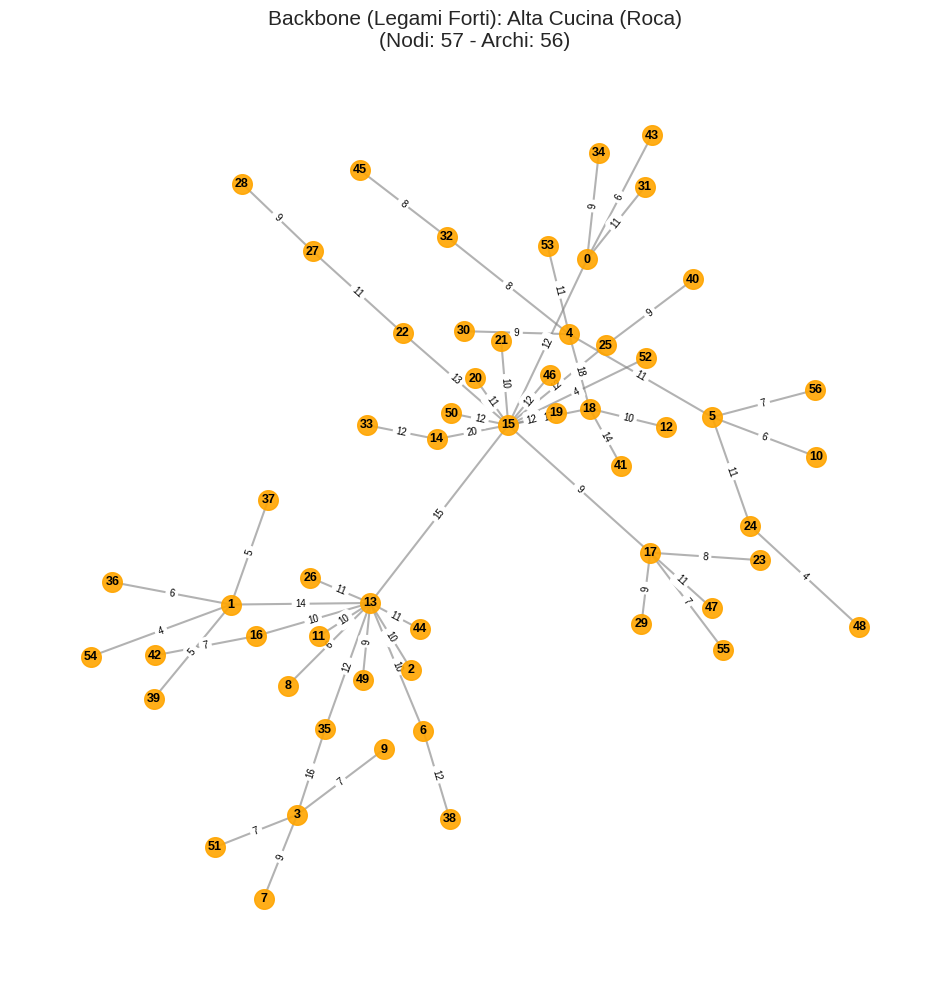

Lettura file: Ctrad_mat_ricette_substitution_output.txt
 -> 160x160 (Simmetrizzazione)... ✅ OK!

--- ANALISI BACKBONE: Substitution (Ctrad) ---
Tabella salvata in: tabella_legami_Substitution.csv
Top 10 Legami più forti:
 Nodo A  Nodo B  Peso (Forza Legame)
     97      99                   14
     22     136                   13
      0       6                   12
     14     136                   12
     21     136                   12
      0     136                   12
      6     147                   12
     97     100                   12
      6     153                   11
    112     139                   11


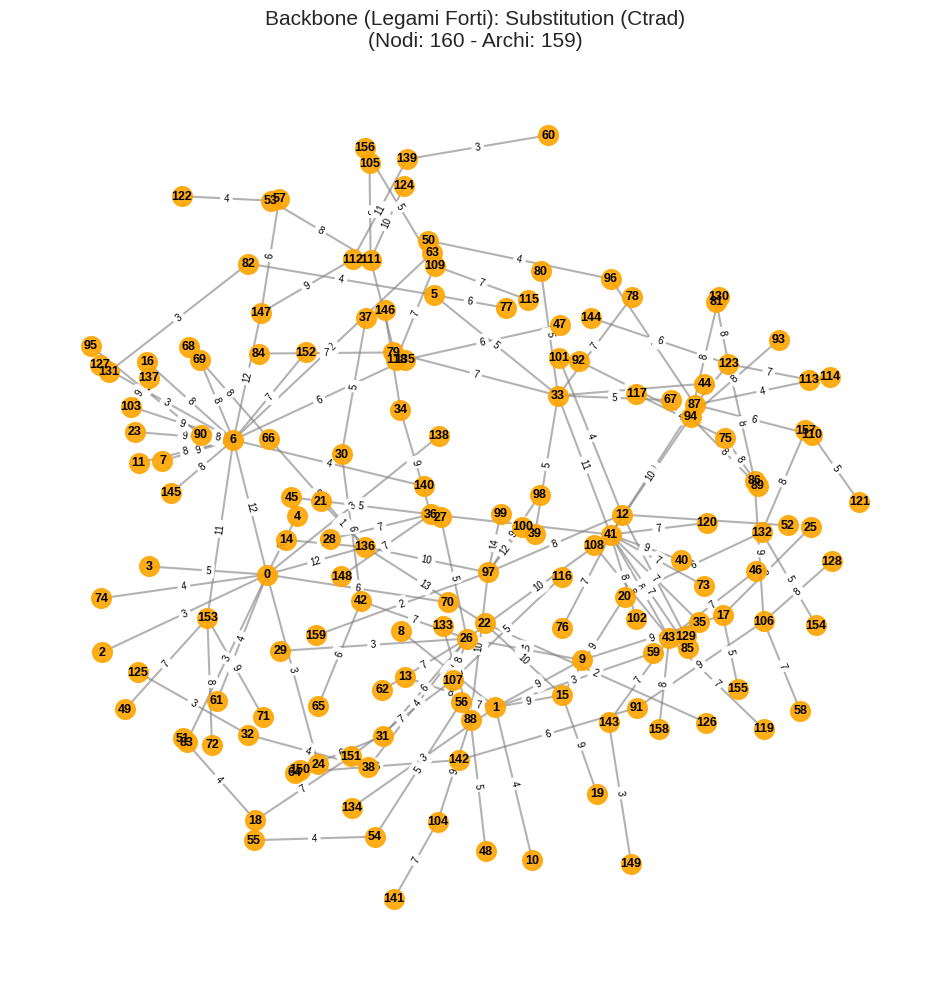


✅ Analisi completata. Controlla i file .png e .csv generati.


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd  # Aggiunto per gestire le tabelle
import re
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# === PARSER ===
def parse_r_output_robust(filepath):
    """
    Legge i file .txt e li converte in matrice.
    """
    data_map = {}
    print(f"Lettura file: {filepath}")

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        for line in lines:
            line = line.strip() # spazi vuoti
            if not line or line.startswith("File:") or "max.print" in line or line.startswith("Simmetrica:") or line.startswith("Matrice:"):
                continue
            if "[" in line and "]" in line and line.strip().startswith("[,"):
                continue

            match = re.match(r'^\[(\d+),\]', line)
            if match:
                row_idx = int(match.group(1))
                content = line[match.end():]
                try:
                    vals = [int(x) for x in content.split()]
                    if row_idx not in data_map:
                        data_map[row_idx] = []
                    data_map[row_idx].extend(vals)
                except ValueError:
                    continue

        if not data_map:
            print("Error: nessun dato trovato.")
            return None

        sorted_indices = sorted(data_map.keys())  # ordiniamo le ricette
        matrix_rows = [data_map[i] for i in sorted_indices]
        min_col_len = min(len(r) for r in matrix_rows)
        trimmed_rows = [r[:min_col_len] for r in matrix_rows]
        matrix = np.array(trimmed_rows) # Matrice NumPy
        limit = min(matrix.shape)
        matrix = matrix[:limit, :limit]

        # simmetrizzazione
        if np.sum(np.tril(matrix, -1)) == 0 and np.sum(np.triu(matrix, 1)) > 0:
            print(f" -> {limit}x{limit} (Simmetrizzazione)...", end="")
            matrix = matrix + matrix.T
        else:
            print(f" -> Recuperata sottomatrice {limit}x{limit}...", end="")

        return matrix

    except Exception as e:
        print(f"Errore lettura: {e}")
        return None

# === BACKBONE E TABELLA ===
def analyze_backbone_and_table(G, name):
    """
     Calcola il Maximum Spanning Tree

    """

    # Maximum Spanning Tree
    T = nx.maximum_spanning_tree(G, weight='weight')

    edges_data = []
    for u, v, data in T.edges(data=True):
        weight = data.get('weight', 0)
        edges_data.append({
            "Nodo A": u,
            "Nodo B": v,
            "Peso (Forza Legame)": weight
        })

    # Cra un DataFrame e ordina
    df_edges = pd.DataFrame(edges_data)
    df_edges = df_edges.sort_values(by="Peso (Forza Legame)", ascending=False)

    csv_filename = f"tabella_legami_{name.split()[0]}.csv"
    df_edges.to_csv(csv_filename, index=False)

    print(f"Tabella salvata in: {csv_filename}")
    print("Top 10 Legami più forti:")
    print(df_edges.head(10).to_string(index=False))

    # Disegno del Grafo
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(T, k=0.5, seed=42)

    # Disegna nodi, archi e etichette
    nx.draw_networkx_nodes(T, pos, node_size=200, node_color='orange', alpha=0.9)
    nx.draw_networkx_edges(T, pos, alpha=0.6, edge_color='gray', width=1.5)
    nx.draw_networkx_labels(T, pos, font_size=9, font_weight='bold')

    edge_labels = nx.get_edge_attributes(T, 'weight')
    relevant_labels = {k: v for k, v in edge_labels.items() if v > 1}
    nx.draw_networkx_edge_labels(T, pos, edge_labels=relevant_labels, font_size=7)

    plt.title(f"Backbone (Legami Forti): {name}\n(Nodi: {T.number_of_nodes()} - Archi: {T.number_of_edges()})", fontsize=15)
    plt.axis('off')

    img_filename = f"backbone_{name.split()[0]}.png"
    plt.savefig(img_filename, dpi=150, bbox_inches='tight')
    plt.show()

# === ESECUZIONE PRINCIPALE ===

files = [
    ("Tradizionale (101)", "101_mat_ricette_output.txt"),
    ("Alta Cucina (Roca)", "Roca_mat_ricette_output.txt"),
    ("Substitution (Ctrad)", "Ctrad_mat_ricette_substitution_output.txt") # Aggiunto Ctrad come richiesto
]

for name, path in files:
    matrix = parse_r_output_robust(path)

    if matrix is not None:
        G = nx.from_numpy_array(matrix)
        G.remove_edges_from(nx.selfloop_edges(G))
        G.remove_nodes_from(list(nx.isolates(G)))

        analyze_backbone_and_table(G, name)

print("\n Analisi completata.")